In [1]:
import sys
root_dir_abspath = '/home/adnen.boumessouer/Anomaly_Detection'

In [2]:
sys.path.insert(0, root_dir_abspath)

In [3]:
import os

import numpy as np
import pandas as pd
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt

from modules.resmaps import calculate_resmaps
from modules.cv import threshold_images
from modules.cv import label_images

from modules.utils import printProgressBar as printProgressBar
import time

from sklearn.metrics import confusion_matrix
from modules import utils as utils
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [4]:
def plot_image(image, cmap="inferno", title=None):
    fig, ax = plt.subplots(figsize=(5, 3))
    im = ax.imshow(image, cmap=cmap, vmin=0, vmax=255)
    ax.set_axis_off()
    fig.colorbar(im)
    plt.title(title)
    plt.show()

## Load arrays
to create these arrays, you either need to have run `train.py` with `--inspect` flag, or run `validation.py` and `test.py` (with dummy `area` and `threshold` arguments) and set the `--save` flag for both.

### Load validation and test (input and pred) images

In [5]:
# change model_dir to try another model 
model_dir = "saved_models/werkstueck/data_a30_nikon_schwarz_occ/mvtec2/SSIM/10-05-2020_15-03-27"

model_abs_path = os.path.join(root_dir_abspath, model_dir)

# change paths if input and pred images are not stored in .../instection
path_val_input = os.path.join(model_abs_path, "inspection_val/imgs_val_input.npy")
path_val_pred = os.path.join(model_abs_path, "inspection_val/imgs_val_pred.npy")

imgs_val_input = np.load(path_val_input, allow_pickle=True)
imgs_val_pred = np.load(path_val_pred, allow_pickle=True)

path_test_input = os.path.join(model_abs_path, "inspection_test/imgs_test_input.npy")
path_test_pred = os.path.join(model_abs_path, "inspection_test/imgs_test_pred.npy")

imgs_test_input = np.load(path_test_input, allow_pickle=True)
imgs_test_pred = np.load(path_test_pred, allow_pickle=True)

## Calculate Resmaps

In [6]:
resmaps_val_ssim = calculate_resmaps(imgs_val_input, imgs_val_pred, method="SSIM")
resmaps_val = img_as_ubyte(resmaps_val_ssim)

resmaps_test_ssim = calculate_resmaps(imgs_test_input, imgs_test_pred, method="SSIM")
resmaps_test = img_as_ubyte(resmaps_test_ssim)

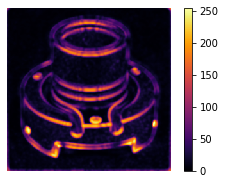

In [7]:
index_val = 0
plot_image(resmaps_val[index_val,:,:,0])

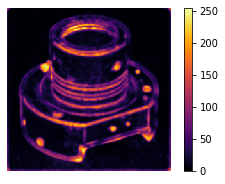

In [8]:
index_test = 10
plot_image(resmaps_test[index_test,:,:,0])

# Determine a good value of `min_area` input argument for validation algorithm (`validation.py`)

## Get basic stats on number of anomalous regions as well as their sum, mean and std size with increasing thresholds

In [9]:
def get_stats(resmaps, th_min=128, th_max=255, plot=False):
    
    dict_stat = {
        "threshold": [],
        "nb_regions": [],
        "mean_areas_size": [],
        "std_areas_size": [],
        "sum_areas_size": [],
    }

    # compute and plot number of anomalous regions and their area sizes with increasing thresholds
    print("computing anomalous regions and area sizes with increasing thresholds...")
    for threshold in range(th_min, th_max + 1):
        # threshold residual maps
        resmaps_th = threshold_images(resmaps, threshold)[:,:,:,0]

        # compute anomalous regions and their size for current threshold
        resmaps_labeled, areas_all = label_images(resmaps_th)
        areas_all_1d = [item for sublist in areas_all for item in sublist]

        # compute the size of the biggest anomalous region (corresponds with smallest threshold)
        if threshold == th_min:
            max_region_size = np.amax(np.array(areas_all_1d))

        nb_regions = len(areas_all_1d)
        if nb_regions == 0:
            break

        mean_areas_size = np.mean(areas_all_1d)
        std_areas_size = np.std(areas_all_1d)
        sum_areas_size = np.sum(areas_all_1d)

        # append values to dictionnary
        dict_stat["threshold"].append(threshold)
        dict_stat["nb_regions"].append(nb_regions)
        dict_stat["mean_areas_size"].append(mean_areas_size)
        dict_stat["std_areas_size"].append(std_areas_size)
        dict_stat["sum_areas_size"].append(sum_areas_size)
        
    df_stat = pd.DataFrame.from_dict(dict_stat)
    
    if plot:
        fig = plt.figure(figsize=(12,8))
        plt.style.use("seaborn-darkgrid")
        ax1 = fig.add_subplot(111)
        lns1 = ax1.plot(df_stat.threshold, df_stat.mean_areas_size, "C0", label="mean_areas_size") #1f77b4
        lns2 = ax1.plot(df_stat.threshold, df_stat.std_areas_size, "C1", label="std_areas_size")
        ax1.set_xlabel("Thresholds")
        ax1.set_ylabel("areas size [number of pixels]")
    
        ax2 = ax1.twinx()
        lns3 = ax2.plot(df_stat.threshold, df_stat.nb_regions, "C2", label="nb_regions") #ff7f0e
        ax2.set_ylabel("number of anomalous regions", color="C2")
        for tl in ax2.get_yticklabels():
            tl.set_color("C2")
        
        lns = lns1+lns2+lns3
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, loc=0)
        
        plt.show()
    
    return df_stat

### Validation stats

computing anomalous regions and area sizes with increasing thresholds...


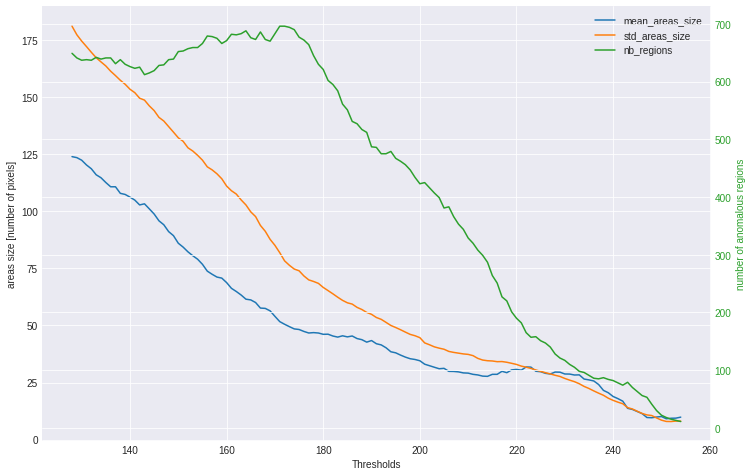

In [10]:
df_stat_val = get_stats(resmaps_val, th_min=128, th_max=255, plot=True)

In [11]:
df_stat_val

,threshold,nb_regions,mean_areas_size,std_areas_size,sum_areas_size
0,128,649,124.030817,181.221780,80496
1,129,641,123.597504,177.468004,79226
2,130,637,122.467818,174.702198,78012
3,131,638,120.374608,172.277695,76799
4,132,637,118.709576,169.777827,75618
...,...,...,...,...,...
122,250,22,10.090909,8.506196,222
123,251,18,9.111111,7.936476,164
124,252,15,9.333333,7.896553,140
125,253,13,9.384615,8.100698,122


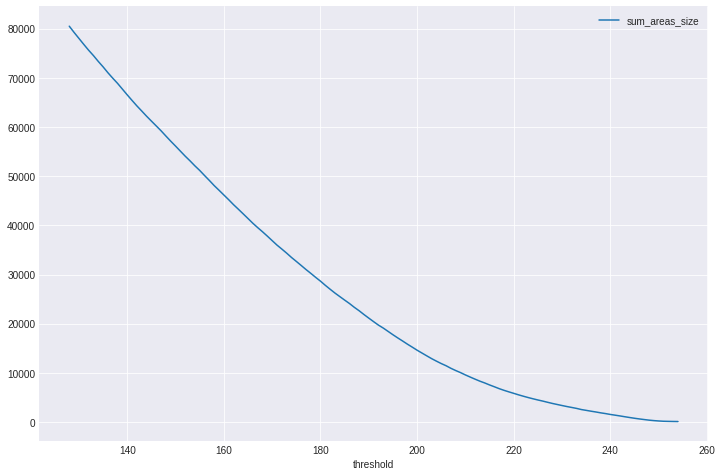

In [12]:
df_stat_val.plot(x="threshold", y=["sum_areas_size"], figsize=(12,8))

### Test stats

computing anomalous regions and area sizes with increasing thresholds...


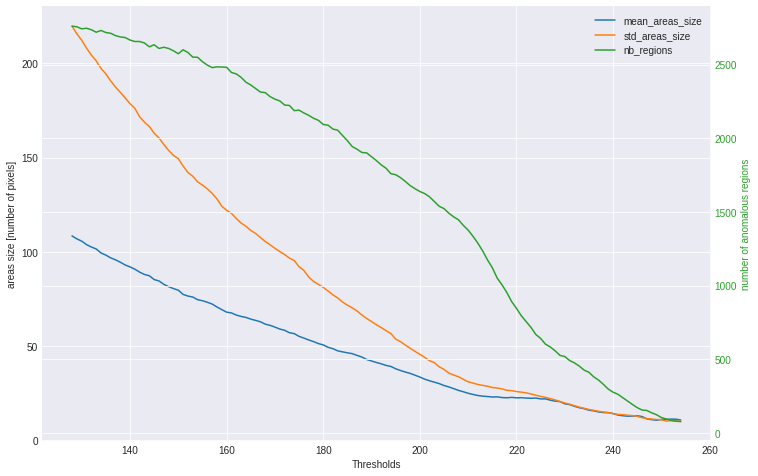

In [13]:
df_stat_test = get_stats(resmaps_test, th_min=128, th_max=255, plot=True)

# Comparison of validation and test Resmaps statistics

###  Merge validation and test DataFrames

In [14]:
# merge df_stats_val with df_stats_test and plot to see difference
mapper_val = {"nb_regions":"nb_regions_val", "mean_areas_size":"mean_areas_size_val", "std_areas_size":"std_areas_size_val", "sum_areas_size":"sum_areas_size_val"}
mapper_test = {"nb_regions":"nb_regions_test", "mean_areas_size":"mean_areas_size_test", "std_areas_size":"std_areas_size_test", "sum_areas_size":"sum_areas_size_test"}
df_stat_val_new = df_stat_val.rename(columns=mapper_val, copy=True)
df_stat_test_new = df_stat_test.rename(columns=mapper_test, copy=True)

In [15]:
df_stat = pd.concat([df_stat_val_new, df_stat_test_new.drop(["threshold"], axis=1)], axis=1, sort=False, join="outer")

In [16]:
df_stat

,threshold,nb_regions_val,mean_areas_size_val,std_areas_size_val,sum_areas_size_val,nb_regions_test,mean_areas_size_test,std_areas_size_test,sum_areas_size_test
0,128,649,124.030817,181.221780,80496,2761,108.488229,219.770294,299536
1,129,641,123.597504,177.468004,79226,2757,106.924193,215.736808,294790
2,130,637,122.467818,174.702198,78012,2743,105.731681,212.365982,290022
3,131,638,120.374608,172.277695,76799,2747,103.889698,208.137087,285385
4,132,637,118.709576,169.777827,75618,2737,102.593350,204.444804,280798
...,...,...,...,...,...,...,...,...,...
122,250,22,10.090909,8.506196,222,105,11.114286,10.955594,1167
123,251,18,9.111111,7.936476,164,95,11.147368,10.252567,1059
124,252,15,9.333333,7.896553,140,86,11.313953,10.450617,973
125,253,13,9.384615,8.100698,122,80,11.262500,10.376348,901


### Scale `nb_of_regions` and `sum_area_size` attributes in test DataFrame to be able to compare with those of validation

The number of validation images is 21, whereas the number of test images is equal to 132. 
This means that we must first normalize the test features of `df_stat` that depend on the number of instances, i.e `nb_of_regions` and `sum_area_size`.

In [17]:
scale_ratio = len(resmaps_val)/len(resmaps_test)
df_stat["nb_regions_test"] = df_stat["nb_regions_test"].map(lambda value: np.ceil(scale_ratio*value))
df_stat["sum_areas_size_test"] = df_stat["sum_areas_size_test"].map(lambda value: np.ceil(scale_ratio*value))

### Plot validation and test statistics

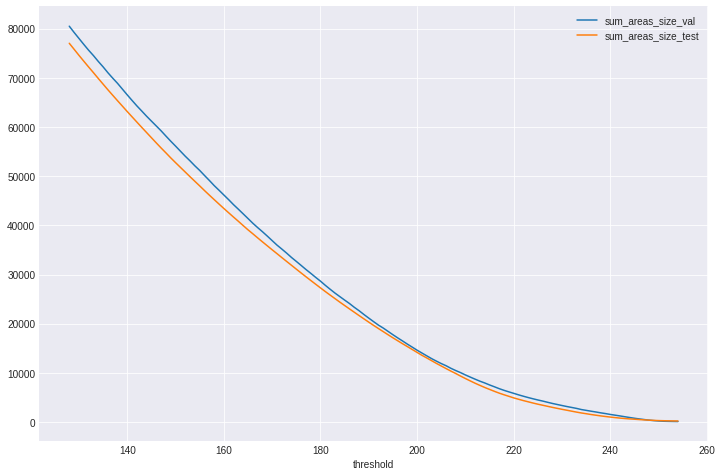

In [18]:
df_stat.plot(x="threshold", y=["sum_areas_size_val", "sum_areas_size_test"], figsize=(12,8))

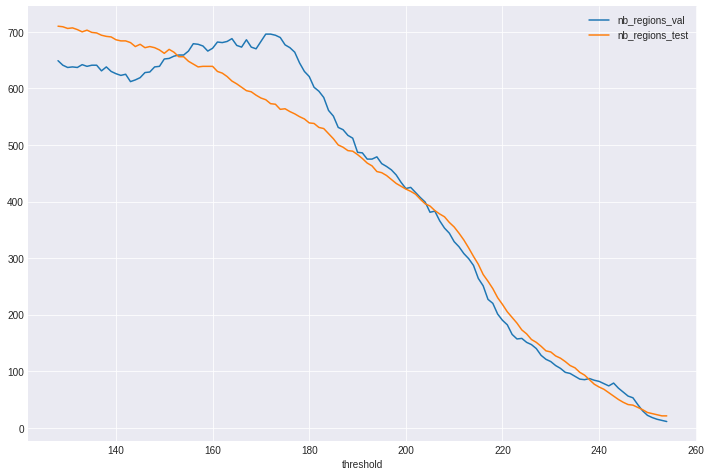

In [19]:
df_stat.plot(x="threshold", y=["nb_regions_val", "nb_regions_test"], figsize=(12,8))

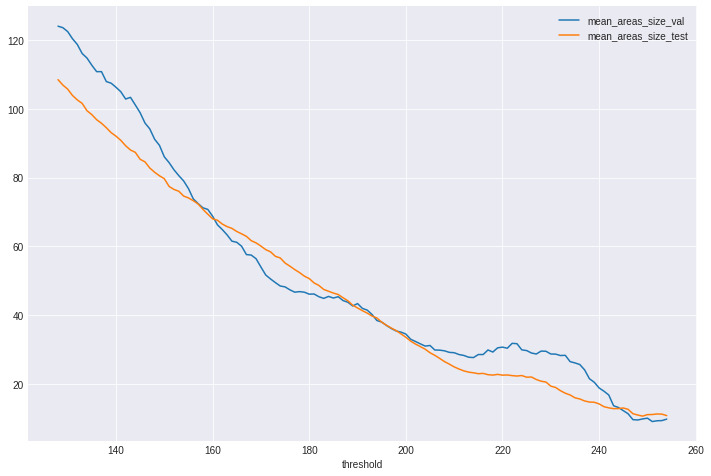

In [20]:
df_stat.plot(x="threshold", y=["mean_areas_size_val", "mean_areas_size_test"], figsize=(12,8))

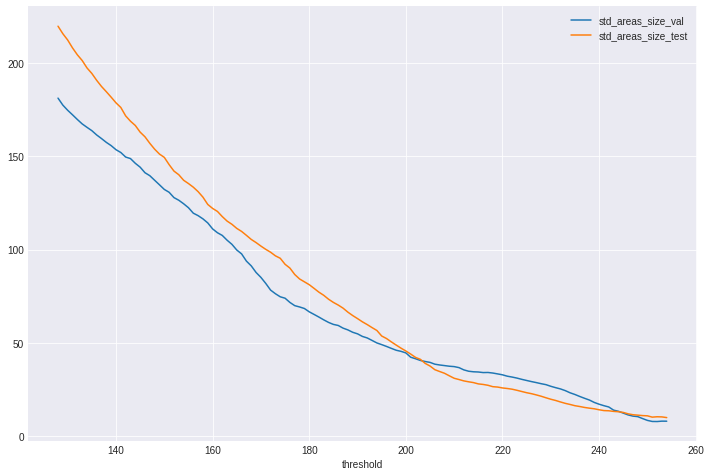

In [21]:
df_stat.plot(x="threshold", y=["std_areas_size_val", "std_areas_size_test"], figsize=(12,8))

### Inspect selected interval

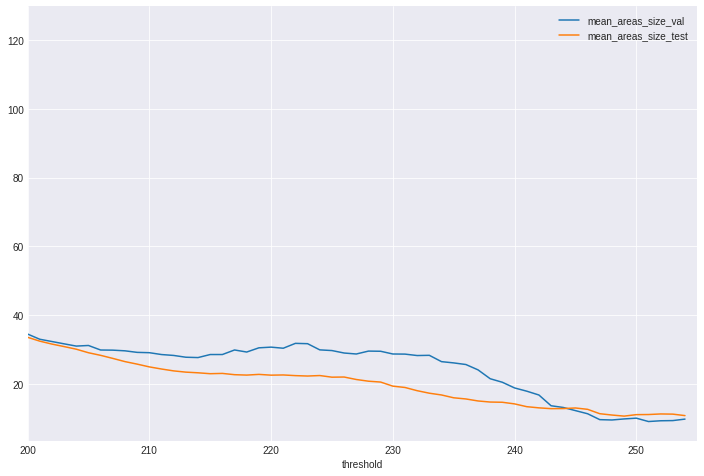

In [22]:
interval = (200,255)
df_stat.plot(x="threshold", y=["mean_areas_size_val", "mean_areas_size_test"], xlim=interval, figsize=(12,8))

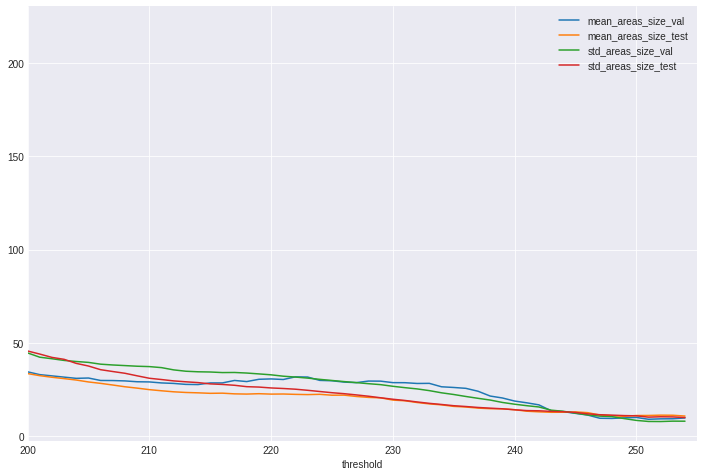

In [23]:
df_stat.plot(x="threshold", y=["mean_areas_size_val", "mean_areas_size_test", "std_areas_size_val", "std_areas_size_test"], xlim=interval, figsize=(12,8))

### Approximate a good value for `min_area`

In [24]:
df_stat[(df_stat["threshold"] >= 200) & (df_stat["nb_regions_val"]>1)][["mean_areas_size_val", "std_areas_size_val", "nb_regions_val"]]

,mean_areas_size_val,std_areas_size_val,nb_regions_val
72,34.541371,44.669975,423
73,33.030588,42.370039,425
74,32.367788,41.552583,416
75,31.695332,40.637857,407
76,31.042607,40.065807,399
77,31.217848,39.590984,381
78,29.900783,38.634534,383
79,29.860656,38.206439,366
80,29.665722,37.877787,353
81,29.215116,37.538123,344


In [25]:
mean_size_segment = df_stat[(df_stat["threshold"] >= 220) & (df_stat["nb_regions_val"]>1)]["mean_areas_size_val"].mean()
mean_size_segment

21.17141965321962

In [26]:
std_size_segment = df_stat[(df_stat["threshold"] >= 220) & (df_stat["nb_regions_val"]>1)]["std_areas_size_val"].mean()
std_size_segment

20.048608808144774

# Simulate Validation in `validation.py`

In [27]:
def calculate_thresholds_from_areas(resmaps_val, min_areas, th_min=128):
    # initialize validation dictionary
    dict_val = {"min_area": [], "threshold": []}
    
    th_max = np.amax(resmaps_val)
    
    # initialize progress bar
    l = len(min_areas)
    printProgressBar(0, l, prefix="Progress:", suffix="Complete", length=50)
    
    # loop over all min_areas and compute corresponding thresholds
    for i, min_area in enumerate(min_areas):
    
        for threshold in range(th_min, th_max + 1):
            # threshold residual maps
            resmaps_th = threshold_images(resmaps_val, threshold)[:,:,:,0]
    
            # compute connected components
            resmaps_labeled, areas_all = label_images(resmaps_th)
    
            # check if area of largest anomalous region is below the minimum area
            areas_all_flat = [item for sublist in areas_all for item in sublist]
            areas_all_flat.sort(reverse=True)
            try:
                if min_area > areas_all_flat[0]:
                    break
            except IndexError:
                continue
    
        # print progress bar
        time.sleep(0.1)
        printProgressBar(i + 1, l, prefix="Progress:", suffix="Complete", length=50)
    
        # append min_area and corresponding threshold to validation dictionary
        dict_val["min_area"].append(min_area)
        dict_val["threshold"].append(threshold)
        
        # create a list containing (min_area, threshold) pairs
        elems_val = list(zip(dict_val["min_area"], dict_val["threshold"]))       
        
    return dict_val, elems_val


#### Simulate validation script with multiple `min_area` input arguments

In [28]:
min_areas = np.arange(start=0, stop=500, step=5)       
dict_val, elems_val = calculate_thresholds_from_areas(resmaps_val, min_areas, th_min=170)
df_val = pd.DataFrame.from_dict(dict_val)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [29]:
df_val

,min_area,threshold
0,0,255
1,5,255
2,10,255
3,15,255
4,20,255
...,...,...
95,475,176
96,480,175
97,485,175
98,490,174


# Simulate Classification in `test.py`

In [30]:
# CLASSIFICATION

def is_defective(areas, min_area):
    """Decides if image is defective given the areas of its connected components"""
    areas = np.array(areas)
    if areas[areas >= min_area].shape[0] > 0:
        return 1
    return 0


def classify(areas_all, min_area):
    """Decides if images are defective given the areas of their connected components"""
    y_pred = []
    for areas in areas_all:
        y_pred.append(is_defective(areas, min_area))
    return y_pred


def calculate_detection_ratios(test_data_dir, resmaps_test, elems):
    
    test_datagen = ImageDataGenerator(
        rescale=None,
        data_format="channels_last",
        preprocessing_function=None,
    )
    
    total_number = utils.get_total_number_test_images(test_data_dir)
    
    # retrieve preprocessed test images as a numpy array
    test_generator = test_datagen.flow_from_directory(
        directory=test_data_dir,
        target_size=(256,256),
        color_mode="grayscale",
        batch_size=total_number,
        shuffle=False,
        class_mode=None,
    )
    
    filenames = test_generator.filenames
    
    # initialize dictionary to store test results
    dict_test = {"min_area": [], "threshold": [], "TPR": [], "TNR": [], "score":[]}
    
    # initialize progress bar
    l = len(elems)
    printProgressBar(0, l, prefix="Progress:", suffix="Complete", length=50)
    
    # classify test images for all (min_area, threshold) pairs
    for i, elem in enumerate(elems):
        # get (min_area, threshold) pair
        min_area, threshold = elem[0], elem[1]
    
        # threshold residual maps with the given threshold
        resmaps_th = threshold_images(resmaps_test, threshold)[:,:,:,0]
    
        # compute connected components
        resmaps_labeled, areas_all = label_images(resmaps_th)
    
        # classify images
        y_pred = classify(areas_all, min_area)
    
        # retrieve ground truth
        y_true = [
            1 if "good" not in filename.split("/") else 0 for filename in filenames
        ]
    
        # save classification of image files in a .txt file
        classification = {
            "filenames": filenames,
            "predictions": y_pred,
            "truth": y_true,
        }
        df_clf = pd.DataFrame.from_dict(classification)
        # with open(os.path.join(save_dir, "classification.txt"), "a") as f:
        #     f.write(
        #         "min_area = {}, threshold = {}, index = {}\n\n".format(
        #             min_area, threshold, i
        #         )
        #     )
        #     f.write(df_clf.to_string(header=True, index=True))
        #     f.write("\n" + "_" * 50 + "\n\n")
    
        # condition positive (P)
        P = y_true.count(1)
    
        # condition negative (N)
        N = y_true.count(0)
    
        # true positive (TP)
        TP = np.sum([1 if y_pred[i] == y_true[i] == 1 else 0 for i in range(total_number)])
    
        # true negative (TN)
        TN = np.sum([1 if y_pred[i] == y_true[i] == False else 0 for i in range(total_number)])
    
        # sensitivity, recall, hit rate, or true positive rate (TPR)
        TPR = TP / P
    
        # specificity, selectivity or true negative rate (TNR)
        TNR = TN / N
        
        # compute score (mean of TPR and TNR)
        score = (TPR + TNR)/2
    
        # confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred, normalize="true")
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, normalize="true").ravel()
    
        # append test results to dictionary
        dict_test["min_area"].append(min_area)
        dict_test["threshold"].append(threshold)
        dict_test["TPR"].append(TPR)
        dict_test["TNR"].append(TNR)
        dict_test["score"].append(score)
    
        # print progress bar
        time.sleep(0.1)
        printProgressBar(i + 1, l, prefix="Progress:", suffix="Complete", length=50)
    
    return dict_test


In [31]:
resmaps_test.shape

(70, 256, 256, 1)

### Test with validation (min_area, threshold) pairs

In [32]:
test_data_dir = "werkstueck/data_a30_nikon_schwarz_occ/test"
test_data_dir_abspath = os.path.join(root_dir_abspath, test_data_dir)

In [33]:
test_data_dir_abspath

'/home/adnen.boumessouer/Anomaly_Detection/werkstueck/data_a30_nikon_schwarz_occ/test'

In [34]:
dict_test_from_val = calculate_detection_ratios(test_data_dir_abspath, resmaps_test, elems_val)
result_test_from_val = pd.DataFrame.from_dict(dict_test_from_val)
result_test_from_val.sort_values(by=["min_area", "threshold"], inplace=True)
result_test_from_val

Found 70 images belonging to 2 classes.
Progress: |██████████████████████████████████████████████████| 100.0% Complete


,min_area,threshold,TPR,TNR,score
0,0,255,0.00000,1.000000,0.500000
1,5,255,0.00000,1.000000,0.500000
2,10,255,0.00000,1.000000,0.500000
3,15,255,0.00000,1.000000,0.500000
4,20,255,0.00000,1.000000,0.500000
...,...,...,...,...,...
95,475,176,0.26087,0.583333,0.422101
96,480,175,0.26087,0.583333,0.422101
97,485,175,0.26087,0.583333,0.422101
98,490,174,0.26087,0.500000,0.380435


### Show best result based on score

In [35]:
result_test_from_val.sort_values(by=["score"], inplace=False).iloc[[-1]]

,min_area,threshold,TPR,TNR,score
52,260,199,0.282609,0.958333,0.620471
